<h1>Results</h1>
<h1>TODO</h1>
<ol>
<li>Bind search methods to Search Structs</li>
<li>Recursive interpolation with DivLut</li>
<li>Smoothness, r^2, absolute distance (mean, 90, max) predicting performance</li>
<li>Mean, 90, 99% distance on 1, 2 interpolations</li>
<li>Hardware Counters</li>
<li>Linear search evaluation</li>
<li>How to use splines to improve interpolation performance?</li>
</ol>
<h1>Notes</h1>
<p>One thing I could do is keep track of a maximum distance from interpolation to final result, and do a binary search on the remaining interval. This combines trusting interpolation search with the asymptotics of binary search. The other benefit is that it reduces how much we touch the workset relative to binary search.</p>
<p>How much does integrating constants degrade the interpolation? Look at integer division interpolation vs LUT interpolation distribution.</p>
<p>Note that two interpolations creates a spline in an ineffective way. You pay for interpolation, NUMA, and several comparisons and you only reduce one half of the end, and you have to do a table lookup to get the interpolation. Two ideas to avoid this. First, splines uniform in the range of the key, so you should be able to find the right spline in a single shift. Second, choose splines that maximize some metric, and do a search to choose, probably a linear search. Either way, doing set of linear splines lets you precompute most of the work.</p>
<p>Another potential optimization to save a subtraction is to insert a 0 element on the left arbitrarily which lets you save in the width subtraction and the first left from right subtraction.</p>
<p>The distance metric that best predicts performance can guide how to choose splines.</p>
<p>Linear search is showing smaller gains on binary search than I remembered.</p>
<p>What about a vectorized binary search? Align the array, load vectors at each point, and go. Similarly for interpolation search, interpolate on the number of vectors rather than the number of elements.</p>

In [22]:
from pandas import read_csv,DataFrame,Series
from os import popen
from subprocess import call,check_output
from math import sqrt,log2
from matplotlib.pyplot import show, plot, table
from scipy.stats import linregress
from sklearn.metrics import r2_score,mean_absolute_error
from heapq import heappush,heappop
from numpy import array,fromiter,int64
from IPython.display import display
Z = 1.96 # Assume 95% confidence interval http://bit.ly/2qszG3k

In [19]:
files = ['input/uniform.1000.' + str(n) for n in range(30)]
algs = 'binary-naive binary-size binary-linear interpolation-naive interpolation-recurse interpolation-linear-fp interpolation-linear'.split()
call('make search N_SAMPLES=1',shell=True)
files_algs_cycles = {file: read_csv(popen('./search {} {}'.format(file,' '.join(algs)))) for file in files}
files_cycles = DataFrame({alg: [float(files_algs_cycles[file][alg]) for file in files] for alg in list(files_algs_cycles[files[0]])},
                        index=files)

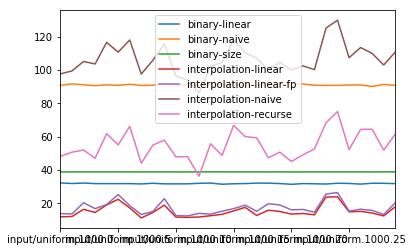

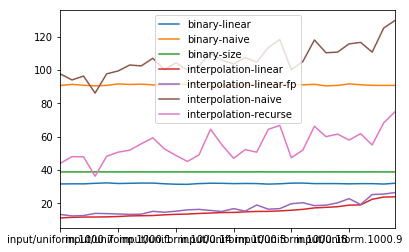

binary-linear               31.869
binary-naive                90.644
binary-size                 38.897
interpolation-linear        14.574
interpolation-linear-fp     16.849
interpolation-naive        103.677
interpolation-recurse       47.084
Name: input/uniform.1000.3, dtype: float64

In [25]:
files_cycles.plot()
files_cycles.sort_values('interpolation-linear').plot()
show()
display(files_cycles.sort_values('interpolation-linear').ix[15])

# Splines
I don't think they're very promising.

In [60]:
def read_ints(file):
    return[int(s) for s in open(file).read().splitlines()[1:]]
def interpolate(x, n, y_l, y_r):
    if n < 1: return 0
    return (x-y_l) // ((y_r - y_l)//n)

def interpolate_s(x,splines):
    spline_ix = len(splines)-1
    for spline_ix,(y_l,y_l_ix) in enumerate(splines):
        if y_l > x:
            spline_ix = spline_ix - 1
            break
    if spline_ix < 0: return -1
    if spline_ix == len(splines) - 1:
        if x > splines[spline_ix][0]: return -1
        spline_ix -= 1
    y_l, l = splines[spline_ix]
    y_r, r = splines[spline_ix+1]
    return l+interpolate(x, r-l, y_l, y_r)

def avg(l):
    return sum(l)/len(l)
def dist(nums):
    return [abs(i - x) for i,x in enumerate(nums)]

nSplines = range(1,300,30)
files = ['input/uniform.1000.{}'.format(i) for i in range(1)]
cmd = './splines {} {}'.format(' '.join(['-f {}'.format(file) for file in files]),
                              ' '.join(['-n {}'.format(n) for n in nSplines]))
#print([l.split() for l in check_output(cmd, shell=True).split(b'\n')])
splines = {(file.decode("utf-8"),int(n)): [int(s) for s in splines_s.split(b',')[:-1]]
          for file, n, splines_s in [l.split() for l in check_output(cmd, shell=True)[:-1].split(b'\n')[1:]]}
#print(splines)
dist_d = {}
for file in files:
    nums = read_ints(file)
    for n in nSplines:
        print(splines[(file,n)])
        t_splines = [(nums[x],x) for x in splines[(file,n)]]
        d = sorted(dist([interpolate_s(x,t_splines) for x in nums]))
        for k,v in [('max',d[-1]),
                    ('90',d[int(len(d)*.9)]),
                    ('avg',avg(d)),
                    ('n_splines', n)]:
            if k not in dist_d: dist_d[k] = [v]
            else: dist_d[k].append(v)
        print(dist_d)
dist_d = DataFrame(dist_d)
# {'max': [5, 5], '90': [4, 3], 'avg': [1.66, 1.39]}


[0, 999]
{'max': [19], '90': [12], 'avg': [6.067], 'n_splines': [1]}
[0, 1, 998, 999]
{'max': [19, 19], '90': [12, 12], 'avg': [6.067, 6.237], 'n_splines': [1, 31]}
[0, 1, 998, 999]
{'max': [19, 19, 19], '90': [12, 12, 12], 'avg': [6.067, 6.237, 6.237], 'n_splines': [1, 31, 61]}
[0, 4, 5, 6, 12, 14, 15, 18, 20, 24, 28, 30, 31, 32, 33, 35, 36, 38, 40, 41, 45, 47, 49, 51, 52, 55, 56, 57, 58, 221, 222, 223, 226, 228, 229, 231, 232, 234, 235, 237, 244, 246, 247, 248, 253, 254, 257, 258, 259, 262, 265, 266, 267, 270, 272, 276, 278, 280, 281, 284, 285, 289, 290, 291, 293, 297, 300, 305, 961, 963, 965, 967, 968, 972, 973, 975, 976, 980, 981, 982, 987, 989, 992, 994, 996, 998, 999]
{'max': [19, 19, 19, 12], '90': [12, 12, 12, 8], 'avg': [6.067, 6.237, 6.237, 3.096], 'n_splines': [1, 31, 61, 91]}
[0, 4, 5, 6, 12, 14, 15, 18, 20, 24, 28, 30, 31, 32, 33, 35, 36, 38, 40, 41, 45, 47, 49, 51, 52, 55, 56, 59, 137, 140, 141, 149, 151, 153, 154, 156, 160, 161, 162, 165, 167, 169, 171, 174, 177, 179, 18

   90    avg  max  n_splines
0  12  6.067   19          1
1  12  6.237   19         31
2  12  6.237   19         61
3   8  3.096   12         91
4   8  2.826   12        121
5   8  2.730   12        151
6   8  2.725   12        181
7   8  2.725   12        211
8   8  2.725   12        241
9   5  1.192    9        271


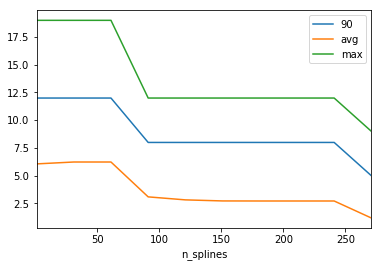

In [61]:

print(dist_d)
dist_d.plot(x='n_splines')
show()

# Mean, 90, 99 on 1, 2 Interpolations

                       90     avg max
                        1       1   1
input/uniform.1000.0   12   6.067  19
input/uniform.1000.1   12   5.850  16
input/uniform.1000.10  11   4.874  19
input/uniform.1000.11   9   4.821  18
input/uniform.1000.12  16   5.585  23
input/uniform.1000.13  13   5.928  24
input/uniform.1000.14  14   7.973  20
input/uniform.1000.15  16   9.490  26
input/uniform.1000.16  29  10.892  35
input/uniform.1000.17  14   7.559  22
input/uniform.1000.18  25  10.904  33
input/uniform.1000.19  21  10.885  28
input/uniform.1000.2   23  11.413  28
input/uniform.1000.20  20   8.580  25
input/uniform.1000.21  17   8.328  21
input/uniform.1000.22  15   6.418  21
input/uniform.1000.23  27  17.262  33
input/uniform.1000.24  36  18.740  44
input/uniform.1000.25  16   7.906  21
input/uniform.1000.26  16   8.856  22
input/uniform.1000.27  15   7.884  19
input/uniform.1000.28  11   5.921  18
input/uniform.1000.29  30  12.165  40
input/uniform.1000.3   15   9.097  23
input/unifor

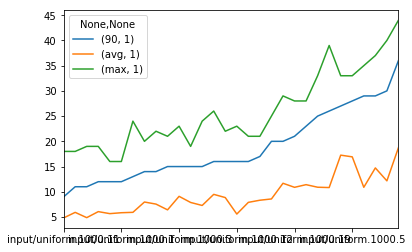

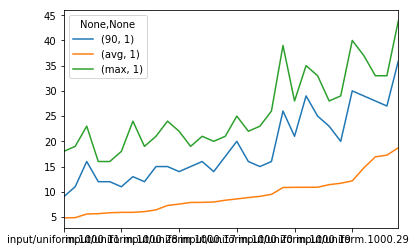

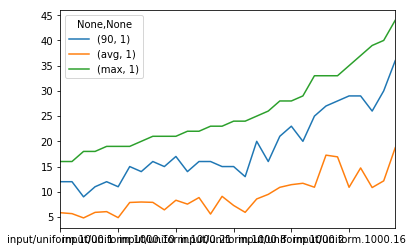

In [80]:
def read_ints(file):
    return[int(s) for s in open(file).read().splitlines()[1:]]
def interpolate(x, nums):
    if len(nums) <= 1: return 0
    return (x-nums[0]) * (len(nums) - 1) // (nums[-1] - nums[0])
def interpolate_n(x, nums, n=1):
    l = 0
    r = len(nums)-1
    for _ in range(n):
        m = l + interpolate(x, nums[l:r+1])
        if x <= nums[m]: r = m
        if x >= nums[m]: l = m
    return m
def avg(l):
    return sum(l)/len(l)
def dist(nums):
    return [abs(i - x) for i,x in enumerate(nums)]
def r2(x,y):
    m, b, r, _, _ = linregress(x,y)
    return r**2

n_iter = [1]
dist_d = {(k,n): {} for k in ['max','90','avg'] for n in n_iter}
#dist_d = {}
regression = []
smoothness = []
for file in ['input/uniform.1000.{}'.format(i) for i in range(30)]:
    nums = read_ints(file)
    for n in n_iter:
        d = sorted( dist([interpolate_n(x,nums,n) for x in nums]))
        dist_d[('max',n)][file] = d[-1]
        #dist_d['50'][file] = d[len(d)//2]
        dist_d[('90',n)][file] = d[int(len(d) * .9)]
        #dist_d['99'][file] = d[int(len(d) * .99)]
        dist_d[('avg',n)][file] = avg(d)

    df = Series([interpolate(x,nums) for x in nums])
    regression.append(r2(df.index, df))
    s_nums = Series(nums)
    gaps = (s_nums[1:].reset_index() - s_nums[:-1].reset_index())[0]
    smoothness.append(max(gaps)/min(gaps))
    
dist_d = DataFrame(dist_d)
print(dist_d)
for c in list(dist_d): dist_d.sort_values(c).plot.line()
show()

# Smoothness, r^2, Distance (mean, 90, max) Predictions
Consider log-log space?

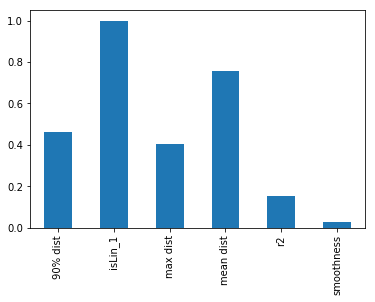

In [48]:
predictors = {
    'max dist': dist_d['max_1'],
    '90% dist': dist_d['90_1'],
    'mean dist': dist_d['avg_1'],
    'r2': regression,
    'smoothness': smoothness,
    'isLin_1': files_cycles['isLin_1']
}
df_predict = DataFrame(predictors, index=files)
df_predict = Series({predictor: r2(df_predict['isLin_1'], df_predict[predictor])
                        for predictor, prediction in predictors.items()})
df_predict.plot.bar()
show()

# Subset Size

In [14]:
call('make p2ibs IS_T=2', shell=True)
cycles = {'nElements': []}
for i in range(0,9):
    nElements = 1000 * 2**i
    df = read_csv(popen('./p2ibs 10 {} < input/um_uniform_1m.txt'.format(nElements)))
    for alg in df:
        if alg not in cycles: cycles[alg] = []
        cycles[alg].append(df[alg].mean())
    cycles['nElements'].append(nElements)

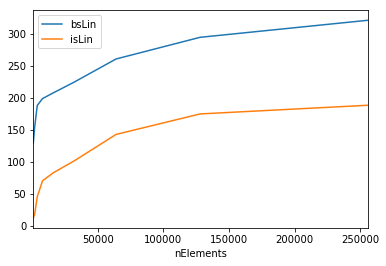

In [15]:
DataFrame(cycles).plot(x='nElements')
show()